<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#Evaluation--Metric" data-toc-modified-id="Evaluation--Metric-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Evaluation  Metric</a></span></li></ul></li><li><span><a href="#Data-preprocessing:" data-toc-modified-id="Data-preprocessing:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing:</a></span></li><li><span><a href="#Predictive-Modeling" data-toc-modified-id="Predictive-Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predictive Modeling</a></span><ul class="toc-item"><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lasso</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Let'-try-out-the-Lasso-model.-I-will-do-a-slightly-different-approach-here-and-use-the-built-in-Lasso-CV-to-figure-out-the-best-alpha." data-toc-modified-id="Let'-try-out-the-Lasso-model.-I-will-do-a-slightly-different-approach-here-and-use-the-built-in-Lasso-CV-to-figure-out-the-best-alpha.-3.2.0.1"><span class="toc-item-num">3.2.0.1&nbsp;&nbsp;</span>Let' try out the Lasso model. I will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha.</a></span></li><li><span><a href="#Let's-add-a-RobustScaler-with-Pipeline,-to-scale-the-variables-before-training-so-we-could-better-compare-coefficients-of-the-regression" data-toc-modified-id="Let's-add-a-RobustScaler-with-Pipeline,-to-scale-the-variables-before-training-so-we-could-better-compare-coefficients-of-the-regression-3.2.0.2"><span class="toc-item-num">3.2.0.2&nbsp;&nbsp;</span>Let's add a RobustScaler with Pipeline, to scale the variables before training so we could better compare coefficients of the regression</a></span></li></ul></li></ul></li><li><span><a href="#Lasso,--Ridge,-RandomForest-and-boosting-models-(with-pipeline)" data-toc-modified-id="Lasso,--Ridge,-RandomForest-and-boosting-models-(with-pipeline)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso,  Ridge, RandomForest and boosting models (with pipeline)</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#SKLearn-Gradient-Boost-Regressor" data-toc-modified-id="SKLearn-Gradient-Boost-Regressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>SKLearn Gradient Boost Regressor</a></span></li><li><span><a href="#XGBM" data-toc-modified-id="XGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>XGBM</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#xgBoost-model-hyperparameter-tuning-with-grid-search" data-toc-modified-id="xgBoost-model-hyperparameter-tuning-with-grid-search-3.6.0.1"><span class="toc-item-num">3.6.0.1&nbsp;&nbsp;</span>xgBoost model hyperparameter tuning with grid search</a></span></li></ul></li></ul></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>LightGBM</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Grid-Search-CV" data-toc-modified-id="Grid-Search-CV-3.7.0.1"><span class="toc-item-num">3.7.0.1&nbsp;&nbsp;</span>Grid Search CV</a></span></li><li><span><a href="#Random-Search-CV" data-toc-modified-id="Random-Search-CV-3.7.0.2"><span class="toc-item-num">3.7.0.2&nbsp;&nbsp;</span>Random Search CV</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#validation-scores" data-toc-modified-id="validation-scores-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>validation scores</a></span></li><li><span><a href="#Final-Training-and-Prediction" data-toc-modified-id="Final-Training-and-Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final Training and Prediction</a></span><ul class="toc-item"><li><span><a href="#Submission" data-toc-modified-id="Submission-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Submission</a></span></li></ul></li></ul></div>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# !pip install lightgbm
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

# Introduction

This is a project that aims to build models to predict the housing price from house features

The dataset include 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. 
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

I'll use this public dataset to highlight some of key tasks involed in a data driven project:
- exploratory data analysis
- data wrangling
- feature engineering
- building ML models (regularized regression, decision tree, bagging and boosting models)
- feature selection and interpretation
- hyperparameters tuning
- model selection


## load data

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [8]:
train.shape

(1460, 81)

In [9]:
test.shape

(1459, 80)

In [10]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Evaluation  Metric

The last column in train dataframe `SalePrice` is our target variable Y. 

To evaluate the performace of predictions models, I used root mean squre error of the log price as evaluation metric instead of the standard root mean squre error. This way, we could compare how close our predictions are in terms of percentages of prices instead of absolute levels, therefore the model won't be driven by how well we predict expensive houses

\begin{equation}
    \sqrt{ \sum \frac{(\ln y - \ln \hat{y})^2}{n} }
\end{equation}

Let's first take a look at what data types our features are

In [11]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [12]:
train.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
# keep all columns from 'MSSubClass':'SaleCondition'

all_X = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [14]:
all_X_copy = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [15]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

In [16]:
all_X_copy[cols]

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,NaN,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,Reg,Y,Pave,NaN,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,NaN,TA,TA,NaN,NaN,TA,TA,Gd,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,7,2006,6
1455,NaN,TA,TA,TA,TA,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,5,2006,4
1456,TA,TA,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,7,2006,9
1457,NaN,Gd,TA,NaN,NaN,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,85,5,2006,7


In [17]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
908,909,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
1273,1274,80,RL,124.0,11512,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2008,WD,Normal,177000
923,924,120,RL,50.0,8012,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,193000
263,264,50,RM,50.0,5500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,130000
50,51,60,RL,NaN,13869,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,177000


In [18]:
all_X.shape

(2919, 79)

# Data preprocessing: 

- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [19]:
# not all numerical type variables are actually numbers, such asMSSubClass, OverallQual, QverallCond...

In [20]:
train.MSSubClass.value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

,price,log(price + 1)
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


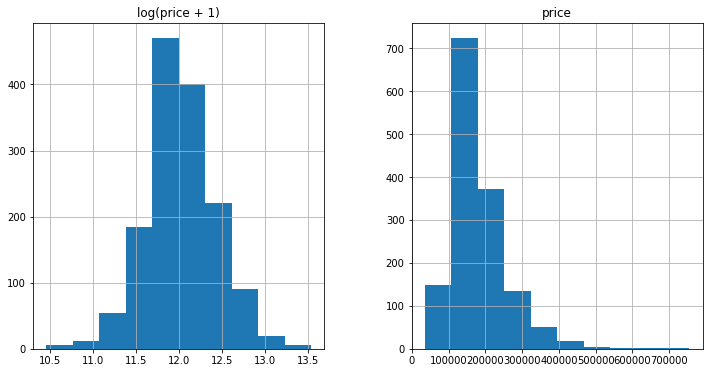

In [21]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
prices.head()

In [22]:
prices.shape

(1460, 2)

In [23]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [24]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index

In [25]:
type(numeric_feats)

pandas.core.indexes.base.Index

In [26]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.648708
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
dtype: float64

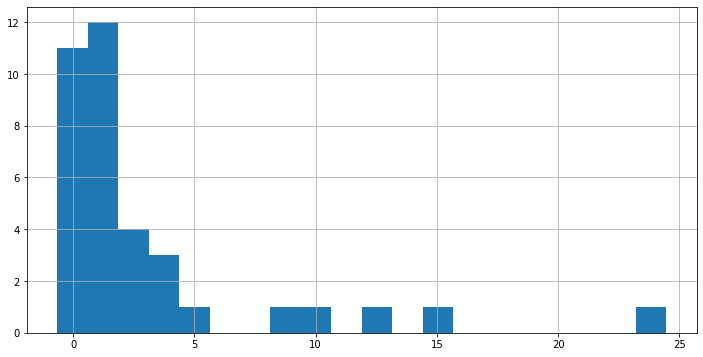

In [27]:
skewed_feats.hist(bins=20)

In [28]:
skewed_feats[skewed_feats > 0.75]

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
dtype: float64

In [29]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [30]:
all_X[skewed_feats] 

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,60,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,...,1710,0.0,1,0,61,0,0,0,0,0
1,20,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,...,1262,1.0,1,298,0,0,0,0,0,0
2,60,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,...,1786,0.0,1,0,42,0,0,0,0,0
3,70,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,...,1717,0.0,1,0,35,272,0,0,0,0
4,60,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,...,2198,0.0,1,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,0.0,0.0,0.0,546.0,546.0,546,546,...,1092,0.0,1,0,0,0,0,0,0,0
1455,160,21.0,1894,0.0,252.0,0.0,294.0,546.0,546,546,...,1092,0.0,1,0,24,0,0,0,0,0
1456,20,160.0,20000,0.0,1224.0,0.0,0.0,1224.0,1224,0,...,1224,0.0,1,474,0,0,0,0,0,0
1457,85,62.0,10441,0.0,337.0,0.0,575.0,912.0,970,0,...,970,1.0,1,80,32,0,0,0,0,700


In [31]:
numeric_data = all_X[skewed_feats]

In [32]:
np.log1p(numeric_data).isnull().sum()

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


MSSubClass         0
LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtHalfBath       2
KitchenAbvGr       0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

In [33]:
np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1455,5.081404,3.091042,7.546974,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,3.218876,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,5.081404,9.903538,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,0.000000,...,7.110696,0.000000,0.693147,6.163315,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.454347,4.143135,9.253591,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,0.000000,...,6.878326,0.693147,0.693147,4.394449,3.496508,0.000000,0.0,0.0,0.0,6.552508


In [34]:
all_X[skewed_feats] = np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [35]:
all_X[skewed_feats].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0


In [36]:
all_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [37]:
all_X.shape

(2919, 79)

In [38]:
#Create Dummy variables for the categorical features

all_X = pd.get_dummies(all_X)

all_X.shape

(2919, 288)

In [39]:
all_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [40]:
#filling NA's with the mean of the column:
all_X = all_X.fillna(all_X.mean())

In [41]:
#creating matrices for sklearn:
X_train = all_X[:train.shape[0]]
X_test = all_X[train.shape[0]:]
y_train = train.SalePrice

In [42]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [43]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [44]:
X_train.shape

(1460, 288)

In [45]:
X_test.shape

(1459, 288)

In [46]:
y_train.shape

(1460,)

# Predictive Modeling



Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning hyperparameters

## Ridge

In [47]:
#Validation function with random shuffle
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [48]:
model_ridge = Ridge()

In [49]:
model_ridge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [50]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)            

In [51]:
cv_ridge

0.05     0.138936
0.10     0.137775
0.30     0.135014
1.00     0.131362
3.00     0.128649
5.00     0.127822
10.00    0.127337
15.00    0.127529
30.00    0.128959
50.00    0.130994
75.00    0.133164
dtype: float64

In [52]:
cv_ridge.min()

0.12733734668670774

In [53]:
cv_ridge.idxmin()

10.0

Text(12, 0.13, 'best alpha')

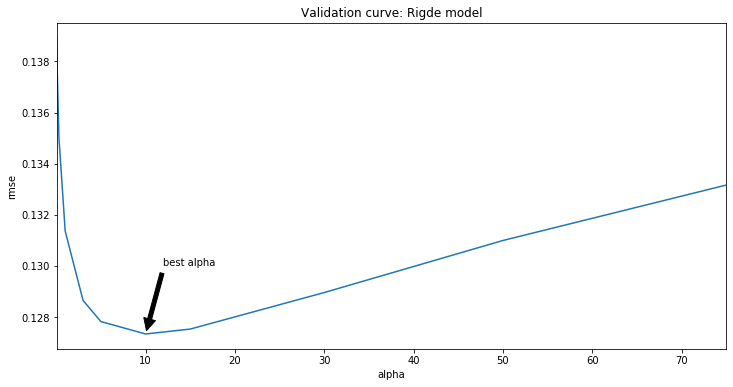

In [54]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
ax = cv_ridge.plot(title = "Validation curve: Rigde model")
ax.set(xlabel='alpha', ylabel='rmse',
       title="Validation curve: Rigde model");
# style = dict(size=10, color='gray')
# ax.text(10, cv_ridge[10]-0.0005, "best alpha",ha='center', **style)
ax.annotate('best alpha', xy=(cv_ridge.idxmin(), cv_ridge.min()), xytext=(12, 0.13),
            arrowprops=dict(facecolor='black', shrink=0.05))

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

So for the Ridge regression we get a rmsle of about 0.127



## Lasso

#### Let' try out the Lasso model. I will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha. 

In [55]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv= 5).fit(X_train, y_train)

In [56]:
# optimal alpha wit cross validation is 0.0005
model_lasso.alpha_

0.0005

In [57]:
model_lasso.alphas_

array([1.e+00, 1.e-01, 1.e-03, 5.e-04])

In [58]:
rmsle_cv(model_lasso)

array([0.10330973, 0.13147319, 0.12552436, 0.10530453, 0.14722499])

In [59]:
rmsle_cv(model_lasso).mean()

0.12256735885048124

#### Let's add a RobustScaler with Pipeline, to scale the variables before training so we could better compare coefficients of the regression

In [60]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))

In [61]:
rmsle_cv(lasso)

array([0.10321219, 0.13149904, 0.12558838, 0.10595377, 0.14660296])

In [62]:
rmsle_cv(lasso).mean()

0.1225712699993513

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [63]:
lasso.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [64]:
# store lasso coefficients
coef = pd.Series(lasso['lasso'].coef_, index = X_train.columns)

In [65]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 112 variables and eliminated the other 176 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [66]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

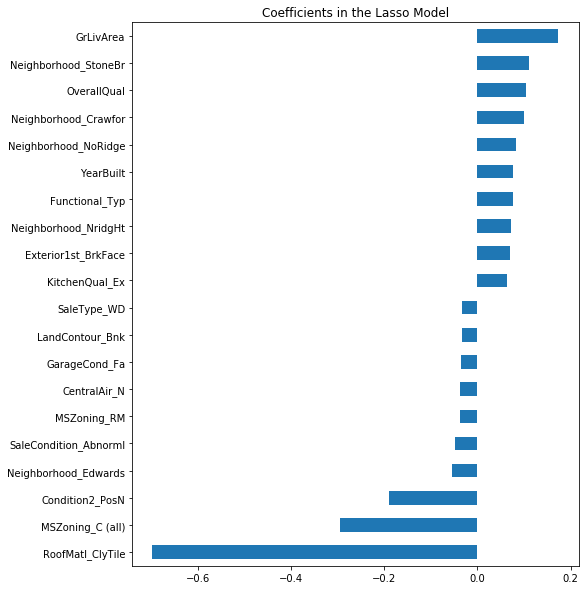

In [67]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## Lasso,  Ridge, RandomForest and boosting models (with pipeline)

Now let's try some other models as well
- random forest
- gradient boost
- xgboost
- lightgbm

## Random Forest

In [68]:
%%time
# Random Forest with hyperparameter tuning
number_of_tree = [10, 20, 50, 75, 100, 150, 200]
cv_RF = [rmsle_cv(RandomForestRegressor(n_estimators = n, random_state=42)).mean()
            for n in number_of_tree]
cv_RF = pd.Series(cv_RF, index = number_of_tree)  

CPU times: user 1min 21s, sys: 868 ms, total: 1min 22s
Wall time: 1min 35s


Text(155, 0.144, '')

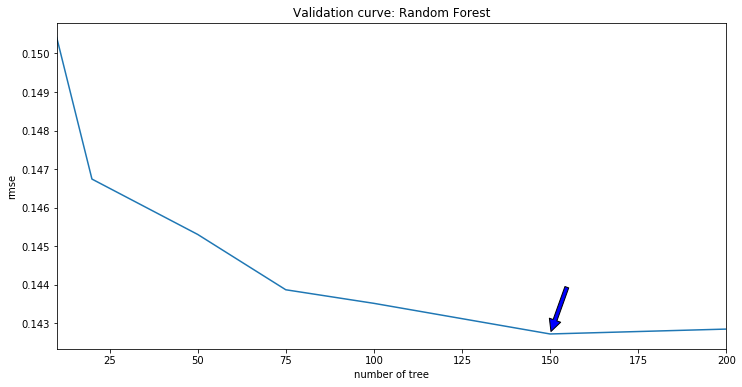

In [69]:

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
ax = cv_RF.plot(title = "Validation curve: Rigde model")
ax.set(xlabel='number of tree', ylabel='rmse',
       title="Validation curve: Random Forest");
ax.annotate('', xy=(cv_RF.idxmin(), cv_RF.min()), xytext=(155, 0.144),
            arrowprops=dict(facecolor='blue', shrink=0.05))

optimal numberof_tree: 150

In [70]:
RF = RandomForestRegressor(n_estimators = 150, random_state=42).fit(X_train,y_train)

In [71]:
RF.feature_importances_.sum()

1.0

Text(0, 0.5, 'Feature Importance Score')

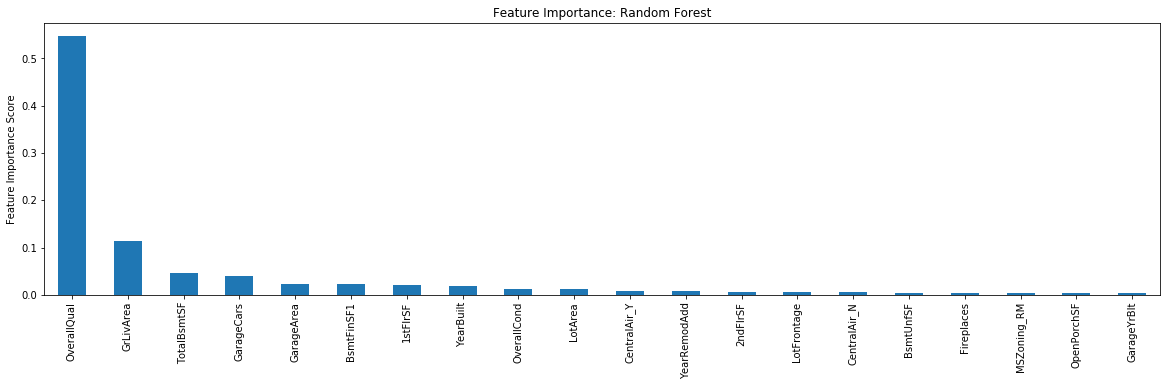

In [72]:
feat_imprf = pd.Series(RF.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feat_imprf = feat_imprf[0:20]
plt.rcParams['figure.figsize'] = 20, 5
feat_imprf.plot(kind='bar', title='Feature Importance: Random Forest')
plt.ylabel('Feature Importance Score')

## SKLearn Gradient Boost Regressor

MSE: 0.0120
Loss: 0.0120


Text(600, 0.04, '')

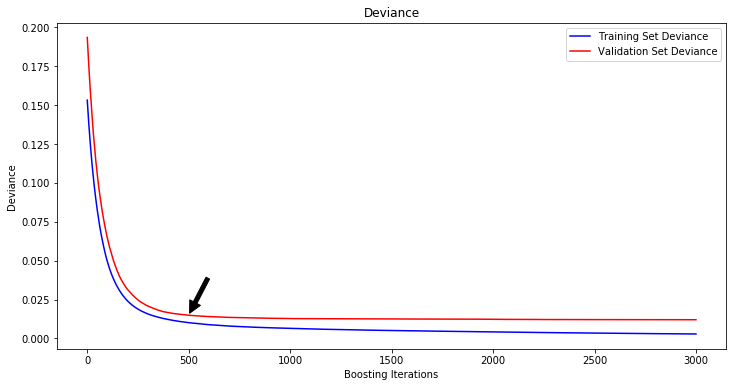

In [73]:
# Gradient Boost hyperparameter tuning
X_train1, X_test1, y_train1 , y_test1 = train_test_split(X_train, y_train, test_size=0.1, random_state=42 )

# #############################################################################

# Fit regression model
params = {'n_estimators': 3000, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train1, y_train1)
mse = mean_squared_error(y_test1, clf.predict(X_test1))
print("MSE: %.4f" % mse)
mse2 = clf.loss_(y_test1, clf.predict(X_test1))
print("Loss: %.4f" % mse2)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test1)):
    test_score[i] = clf.loss_(y_test1, y_pred)

plt.figure(figsize=(12, 6))

plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.annotate('', xy=(500, test_score[500]), xytext=(600, 0.04),
            arrowprops=dict(facecolor='black', shrink=0.05))

After 500 interations, there isn't much gain on the performance seen from the validation set, we'll stop there 

In [74]:
GB = GradientBoostingRegressor(n_estimators=500, random_state=42).fit(X_train,y_train)


What are the importance feature given by GBoosting model?

Text(0, 0.5, 'Feature Importance Score')

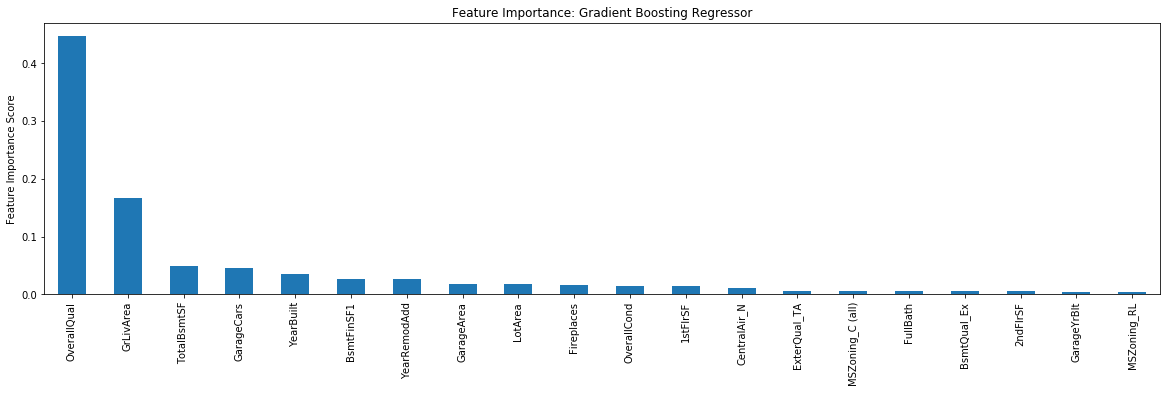

In [75]:
feat_impgb = pd.Series(GB.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feat_impgb = feat_impgb[0:20]
plt.rcParams['figure.figsize'] = 20, 5
feat_impgb.plot(kind='bar', title='Feature Importance: Gradient Boosting Regressor')
plt.ylabel('Feature Importance Score')

As we could see, the top 5 or 10 features from random forest and gradient boosting model are very similar: `OverallQual` `GrLivArea` `TotalBsmtSF` `GarageCars` `YearBuilt` are among the most important features for prediciting house price

## XGBM

#### xgBoost model hyperparameter tuning with grid search

In [76]:
%%time
# xgb Boost hyperparameter tuning: 
estimator = xgb.XGBRegressor(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500]
}

xgbm = GridSearchCV(estimator, param_grid, cv=3)
xgbm.fit(X_train, y_train)


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:21:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:21:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:21:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:21:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 19s, sys: 345 ms, total: 2min 19s
Wall time: 2min 20s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [25, 50, 100, 150, 

In [77]:
print('Best parameters found by grid search are:', xgbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 500}


In [78]:
xgb.XGBRegressor(n_estimators=500,learning_rate=0.1, random_state=42)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

what are the important features?

Text(0, 0.5, 'Feature Importance Score')

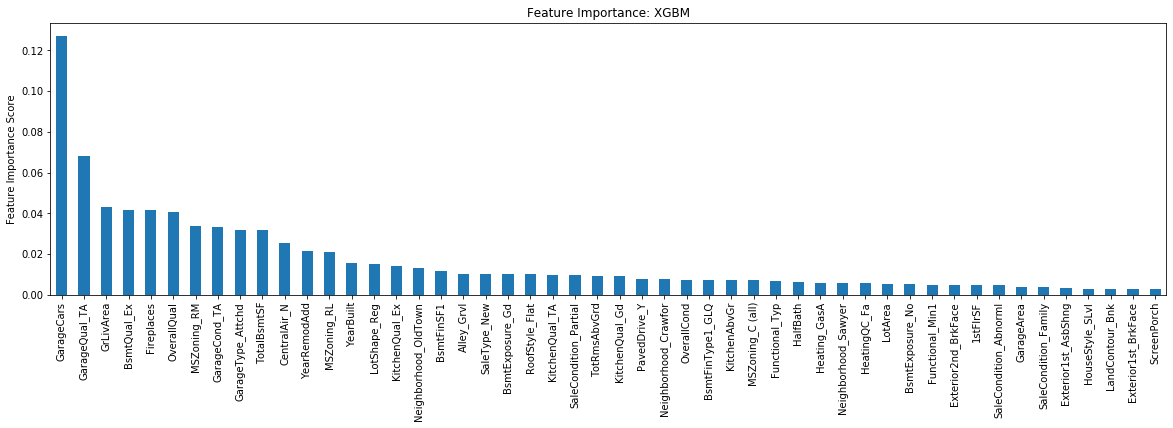

In [79]:
predictors = [x for x in X_train.columns]
feat_impxgbm = pd.Series(xgbm.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_impxgbm = feat_impxgbm[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_impxgbm.plot(kind='bar', title='Feature Importance: XGBM')
plt.ylabel('Feature Importance Score')

In [80]:
feat_impxgbm[:10]

GarageCars           0.127053
GarageQual_TA        0.068016
GrLivArea            0.043049
BsmtQual_Ex          0.041619
Fireplaces           0.041549
OverallQual          0.040825
MSZoning_RM          0.033805
GarageCond_TA        0.033145
GarageType_Attchd    0.031996
TotalBsmtSF          0.031849
dtype: float32

## LightGBM

#### Grid Search CV

In [105]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500]
}

lgbm = GridSearchCV(estimator, param_grid, cv=3)
lgbm.fit(X_train, y_train)



CPU times: user 33.7 s, sys: 598 ms, total: 34.3 s
Wall time: 39.8 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [25, 50, 100, 150, 200, 500]},
             pre_dispatch='2*n_jobs',

In [106]:
print('Best parameters found by grid search are:', lgbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 200}


In [82]:
%%time
tempa = rmsle_cv(lgbm)

CPU times: user 1min 59s, sys: 1.41 s, total: 2min 1s
Wall time: 2min 1s


In [83]:
tempa

array([0.12333927, 0.14383463, 0.13534785, 0.11816547, 0.13339808])

In [84]:
tempb = rmsle_cv(lgb.LGBMRegressor(n_estimators = 200,learning_rate=0.05, random_state=42))

In [85]:
tempb

array([0.12187792, 0.14383463, 0.13534785, 0.11816547, 0.13339808])

In [86]:
tempb.mean()

0.13052478879838142

Text(0, 0.5, 'Feature Importance Score')

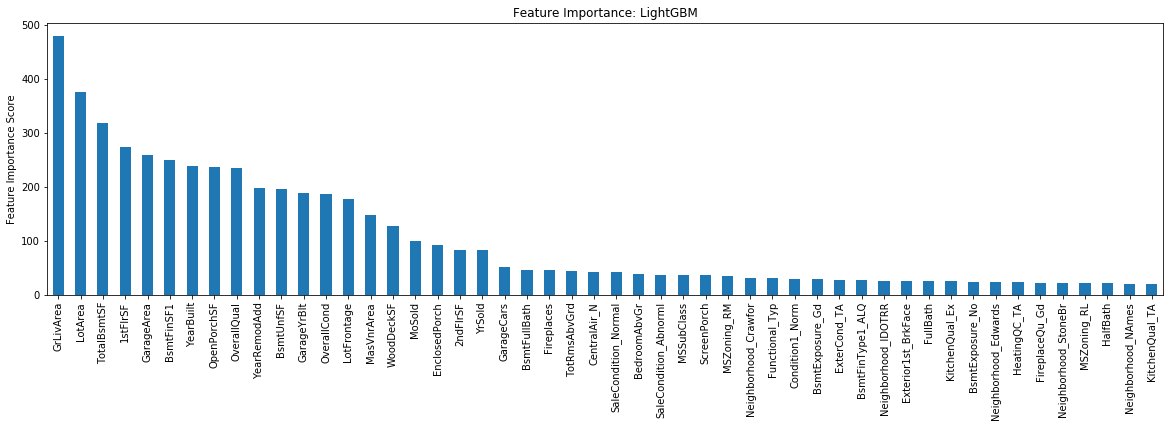

In [87]:
feat_implgbm = pd.Series(lgbm.best_estimator_.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feat_implgbm = feat_implgbm[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_implgbm.plot(kind='bar', title='Feature Importance: LightGBM')
plt.ylabel('Feature Importance Score')

In [88]:
feat_implgbm[:10]

GrLivArea       479
LotArea         375
TotalBsmtSF     317
1stFlrSF        273
GarageArea      258
BsmtFinSF1      250
YearBuilt       239
OpenPorchSF     236
OverallQual     234
YearRemodAdd    198
dtype: int32

#### Random Search CV

In [89]:
lgbm.estimator

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
#grid of parameters
gridParams = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500],
    'boosting_type' : ['gbdt'],
    'max_depth' : [5,6,7,8],
    'random_state' : [42], 
}

In [91]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)
randgrid = RandomizedSearchCV(estimator,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
randgrid.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished


CPU times: user 1.6 s, sys: 182 ms, total: 1.78 s
Wall time: 23.9 s


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg...
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                        

In [92]:
randgrid.best_params_

{'random_state': 42,
 'n_estimators': 200,
 'max_depth': 6,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [93]:
tempc = rmsle_cv(lgb.LGBMRegressor(n_estimators = 500,learning_rate=0.1, max_depth=8, random_state=42))

In [94]:
tempc

array([0.1228968 , 0.1408065 , 0.14064589, 0.12446927, 0.13231924])

In [95]:
tempc.mean()

0.13222753936923692

Text(0, 0.5, 'Feature Importance Score')

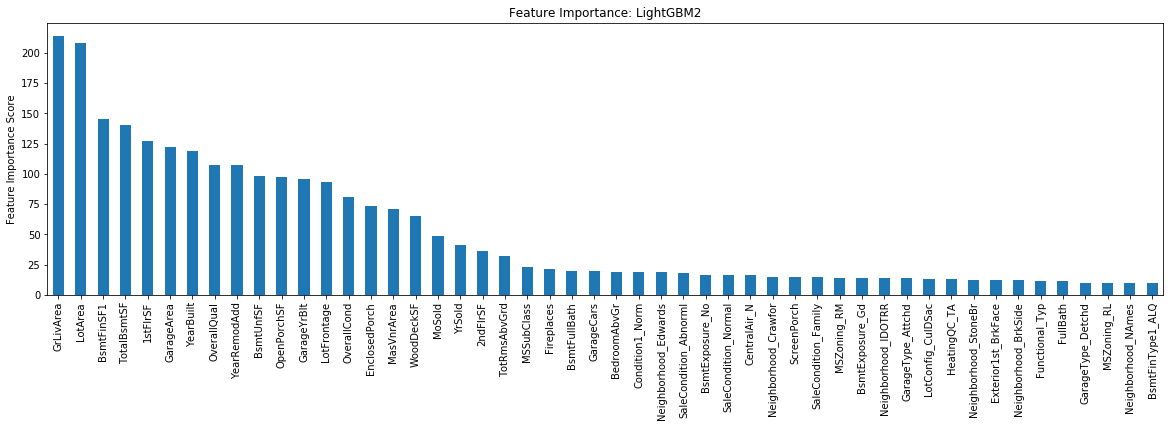

In [96]:
predictors = [x for x in X_train.columns]
feat_implgbm2 = pd.Series(randgrid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_implgbm2 = feat_implgbm2[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_implgbm2.plot(kind='bar', title='Feature Importance: LightGBM2')
plt.ylabel('Feature Importance Score')

In [97]:
feat_implgbm2[:10]

GrLivArea       214
LotArea         208
BsmtFinSF1      145
TotalBsmtSF     140
1stFlrSF        127
GarageArea      122
YearBuilt       119
OverallQual     107
YearRemodAdd    107
BsmtUnfSF        98
dtype: int32

# validation scores

In [98]:
models = {"lasso": make_pipeline(RobustScaler(), Lasso(alpha =0.0005)),
          "Enet" : make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9)),
          "ridge": make_pipeline(RobustScaler(), Ridge(alpha =10)),
          "RandomForest": RandomForestRegressor(n_estimators = 150, random_state=42),
          "GradientBoost": GradientBoostingRegressor(n_estimators=500, random_state=42),
          "xGBM": xgb.XGBRegressor(n_estimators=500,learning_rate=0.1, random_state=42),
          "LightGBM": lgb.LGBMRegressor(n_estimators = 200,learning_rate=0.05, random_state=42),
         "LightGBM2": lgb.LGBMRegressor(n_estimators = 500,learning_rate=0.1, max_depth=8, random_state=42)}

for name, model in models.items():
    score = rmsle_cv(model)
    print("\n Model {}'s validation score: {:.4f} and standard deviation: ({:.4f})\n".format(name,score.mean(), score.std()))


 Model lasso's validation score: 0.1226 and standard deviation: (0.0162)


 Model Enet's validation score: 0.1226 and standard deviation: (0.0163)


 Model ridge's validation score: 0.1264 and standard deviation: (0.0156)


 Model RandomForest's validation score: 0.1427 and standard deviation: (0.0089)


 Model GradientBoost's validation score: 0.1237 and standard deviation: (0.0099)

[17:25:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:25:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:25:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:25:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:25:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 Model xGBM's validation score: 0.1240 and standard deviation: (0.0101)


 Model LightGBM's validation score: 0.1305 and standard deviation: (0.0093)


 Model LightGBM2's validation score: 0.1322 and standard deviation: (0.0076)



We could see, our random forest model performed a bit worse and the boosting models improved the performance to about the same level as the regularized regression models

# Final Training and Prediction


we need to fit models first

In [99]:
models = {"lasso": make_pipeline(RobustScaler(), Lasso(alpha =0.0005)),
          "Enet" : make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9)),
          "ridge": make_pipeline(RobustScaler(), Ridge(alpha =10)),
          "RandomForest": RandomForestRegressor(n_estimators = 150, random_state=42),
          "GradientBoost": GradientBoostingRegressor(n_estimators=500, random_state=42),
          "xGBM": xgb.XGBRegressor(n_estimators=500,learning_rate=0.1, random_state=42),
          "LightGBM": lgb.LGBMRegressor(n_estimators = 200,learning_rate=0.05, random_state=42),
         "LightGBM2": lgb.LGBMRegressor(n_estimators = 500,learning_rate=0.1, max_depth=8, random_state=42)}

for name, model in models.items():
    model.fit(X_train,y_train)

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:26:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [100]:
# model names used: lasso, RF, GB, xgbm, lgbm
# old models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]

Let's makes some plot(Plot residuals of prediction under different models)

In [101]:
# define a function wrapper 
def plot_prdiction_residual(model, name):
    preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter", ylim=(-1, 0.5),title="Prediction vs Residual:"+name)
    return

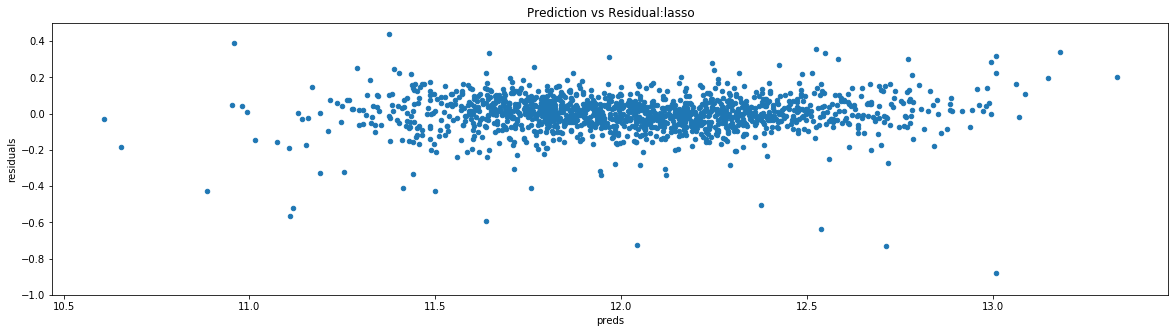

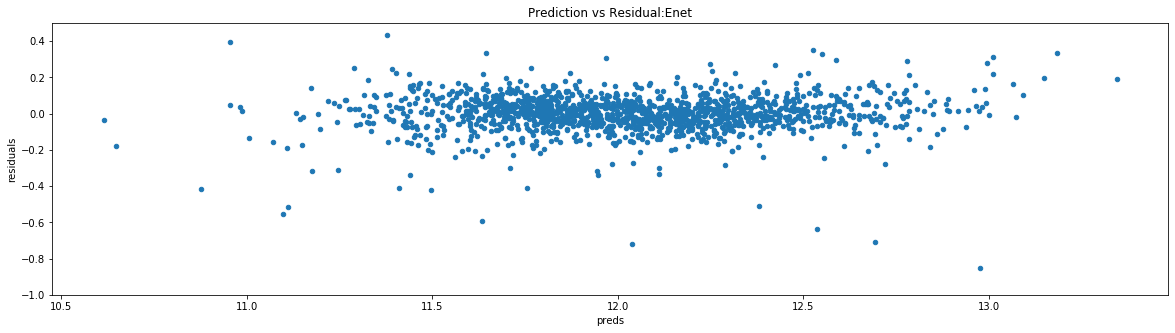

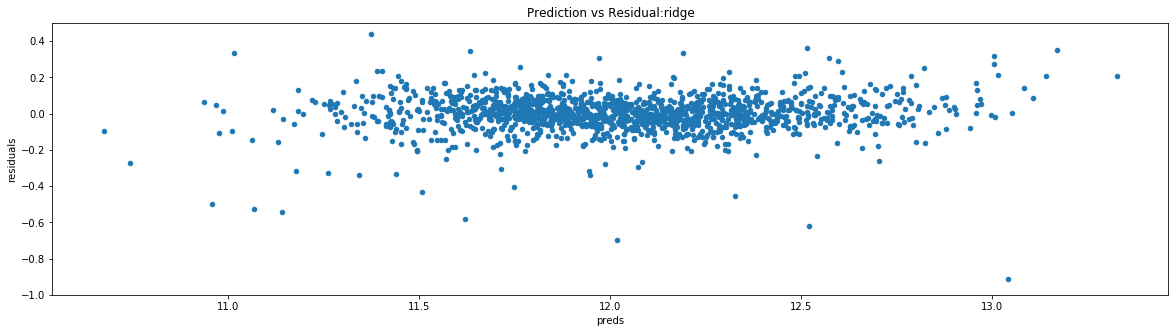

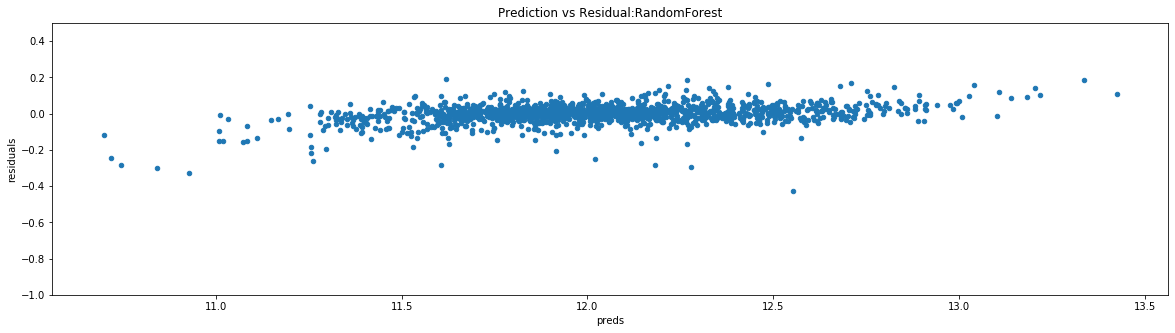

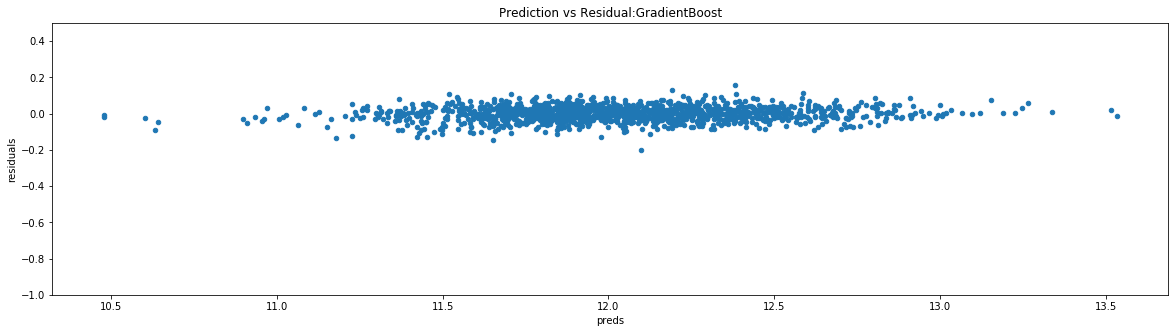

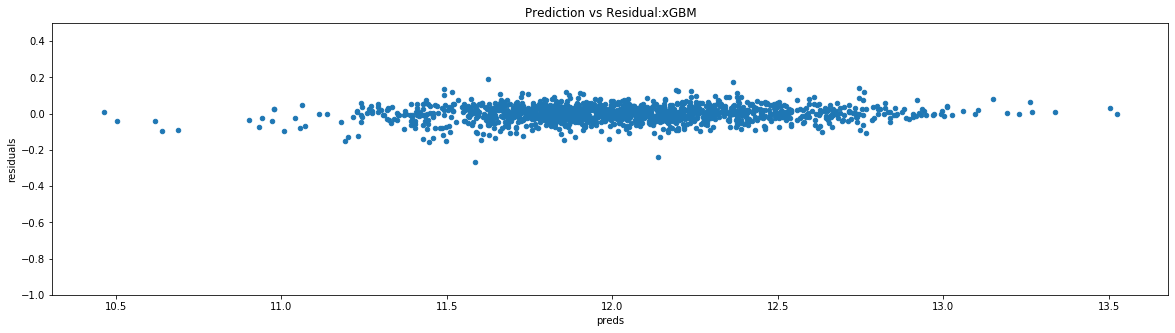

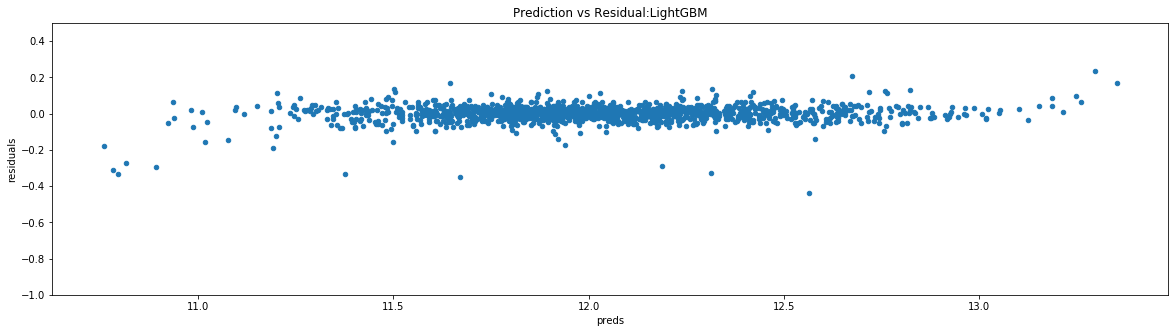

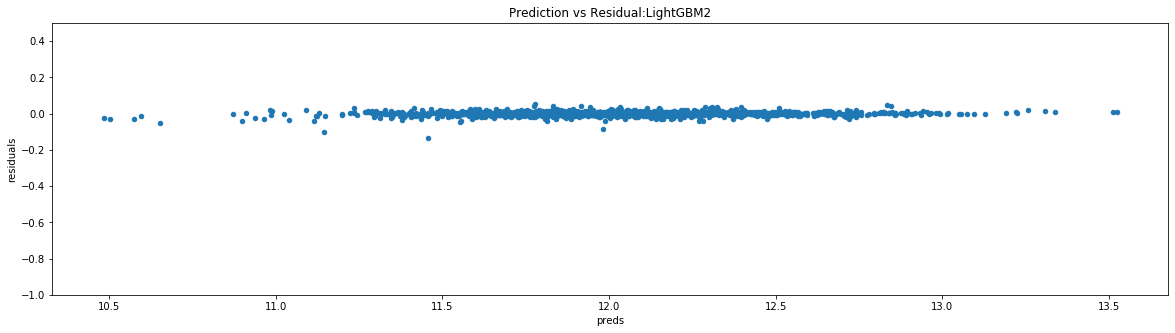

In [102]:
for name, model in models.items():
    plot_prdiction_residual(model, name)

See how we did on training set

In [103]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [104]:
print("Evaluation  Metric achieved on Training data: ")
for name, model in models.items():
    print(name, rmsle(y_train, model.predict(X_train)))

Evaluation  Metric achieved on Training data: 
lasso 0.10497900918329381
Enet 0.10403585205697068
ridge 0.10478035960262716
RandomForest 0.05269542209568835
GradientBoost 0.0393650952593161
xGBM 0.04357523757789634
LightGBM 0.04632200056845063
LightGBM2 0.011950035850837867


## Submission

In [210]:

sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
